# **0. Intro**

In [1]:
# to display all the outputs
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from google.colab import drive
drive.mount('/content/drive')
import sys
nb_path = "/content/drive/My Drive/NeuralODE/Media"
if nb_path not in sys.path:
  sys.path.insert(5, nb_path)

!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y --prefix /usr/local jupyter
!python -m ipykernel install --name "py38" --user

!pip install git+https://github.com/DiffEqML/torchdyn.git

Mounted at /content/drive
--2022-02-28 11:19:13--  https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89817099 (86M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  85.66M   191MB/s    in 0.4s    

2022-02-28 11:19:13 (191 MB/s) - ‘mini.sh’ saved [89817099/89817099]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py38_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py38_0
    - cffi==1.14.0=py38h2e261b9_0
    - chardet==3.0.4=py38_1003
    - conda-package-handling==1.6.0=py38h7b6447c_0
    - conda==4.8.2=py38_

# **1. Libraries**

In [2]:
sys.path.append('/usr/local/lib/python3.8/site-packages/')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *

import torch
import torch.utils.data as data

import torch.nn as nn
import pytorch_lightning as pl

import os

%load_ext autoreload
%autoreload 2
# quick run for automated notebook validation

# **2. Parameters**

In [3]:
# Parameters
dry_run = False

# **3. Dataset**

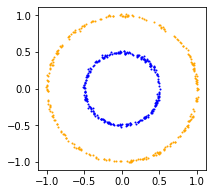

In [4]:
device=torch.device("cpu")

d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-2, dataset_type='spheres', dim=2)
import matplotlib.pyplot as plt

colors = ['orange', 'blue'];
fig = plt.figure(figsize=(3,3));
ax = fig.add_subplot(111);
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()]);

# **4. Transform Dataset**

In [5]:
device = torch.device("cpu") # all of this works in GPU as well :)

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

# **5. Training**

In [6]:
t_span = torch.linspace(0,1,50)

f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Tanh(),
        nn.Linear(64, 2)
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)
learn = Learner(t_span, model)

if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=300, max_epochs=800)
trainer.fit(learn)
print(learn)
print("------")
print(model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."
Missing logger folder: /content/lightning_logs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 322   
------------------------------------
322       Trainable params
0         Non-trainable params
322       Total params
0.001     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Learner(
  (model): Neural ODE:
  	- order: 1        
  	- solver: RungeKutta4()
  	- adjoint solver: DormandPrince45()        
  	- tolerances: relative 0.001 absolute 0.001        
  	- adjoint tolerances: relative 0.0001 absolute 0.0001        
  	- num_parameters: 322        
  	- NFE: 510400.0
)
------
Neural ODE:
	- order: 1        
	- solver: RungeKutta4()
	- adjoint solver: DormandPrince45()        
	- tolerances: relative 0.001 absolute 0.001        
	- adjoint tolerances: relative 0.0001 absolute 0.0001        
	- num_parameters: 322        
	- NFE: 510400.0


# **6. Plot**

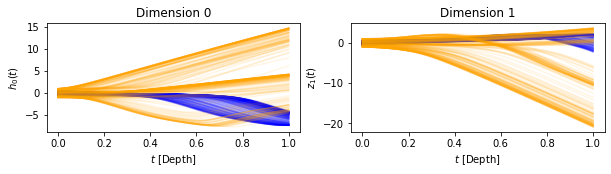

In [7]:
t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2));
ax0 = fig.add_subplot(121);
ax1 = fig.add_subplot(122);
for i in range(500):
    ax0.plot(t_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(t_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);

ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$");
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$");
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1");

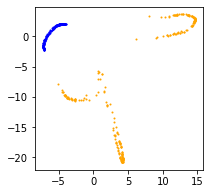

In [8]:
colors = ['orange', 'blue'];
fig = plt.figure(figsize=(3,3));
ax = fig.add_subplot(111);

j=49
for i in range(500):
  ax.scatter(trajectory[j,i,0], trajectory[j,i,1], s=1, color=colors[yn[i].int()]);

In [9]:
# Evaluate vector field
n_pts = 10
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
XX, YY = torch.meshgrid(x, y)
z = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], 1)
t_eval_f, trajectory_f = model(z, t_span)

derivative = trajectory_f
dt = t_eval[1] - t_eval[0]
for i in range(len(t_eval)-1):
    derivative[i] = (trajectory_f[i+1, :, :] - trajectory_f[i, :, :]) / dt

derivative = derivative.detach().numpy()
z = z.detach().numpy()

try:
  os.mkdir(os.path.join(nb_path, "anelli_concentrici"))
except Exception as e:
  print("Folder already exists")

plt.ioff()
colors = ['orange', 'blue']
for j in range(len(t_span)):
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(111)
  for i in range(len(z)):
    ax.quiver(z[i, 0], z[i, 1], derivative[j, i, 0], derivative[j, i, 1], color='black', alpha = 0.2)
  for i in range(len(X)):
    ax.scatter(trajectory[j,i,0], trajectory[j,i,1], s=30, color=colors[yn[i].int()])
  fig.savefig(os.path.join(nb_path, "anelli_concentrici", "anelli_concentrici_" + str(j)) , dpi=150)
  plt.close(fig)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Folder already exists
